In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
import folium 

In [2]:
degree = 2

In [3]:
data = pd.read_csv('/home/grzegorz/Pulpit/Projects/Airly/LDA/airly_data.csv')
data = data[['start_date', 'PM10', 'installation_id', 'Temperature']]
data.start_date = pd.to_datetime(data.start_date)
data = data.sort_values(by = 'start_date').reset_index(drop=True)
data = data.replace('None', np.nan)
data = data.dropna()

In [4]:
data.shape

(753108, 4)

In [5]:
installations = data.installation_id.drop_duplicates().tolist()
count = data.groupby('installation_id').count().sort_values(by='PM10')
count = count[count.PM10 > 100]
count = count.index.tolist()
installations = list(set(installations).intersection(set(count)))
len(installations)

950

In [6]:
polynomial_features= PolynomialFeatures(degree=degree)

In [7]:
def polynomial_regression(data, installation):
    tmp = data[data.installation_id == installation]
    PR = LinearRegression(n_jobs=1)
    x = polynomial_features.fit_transform(np.array(tmp.Temperature).reshape(-1, 1))
    y = tmp.PM10
    PR.fit(x, y)
    return PR.coef_, installation

In [8]:
%%time
coeffs = []
for i in installations:
    c, _ = polynomial_regression(data, i)
    coeffs.append(c)
beta0 = [coeffs[i][0] for i in range(len(coeffs))]
beta1 = [coeffs[i][1] for i in range(len(coeffs))]
if degree == 2:
    beta2 = [coeffs[i][2] for i in range(len(coeffs))]
else:
    beta2 = [0 for i in range(len(coeffs))]

CPU times: user 18.9 s, sys: 236 ms, total: 19.2 s
Wall time: 3.21 s


In [9]:
d = {'installation_id': installations, 'beta0': beta0, 'beta1': beta1, 'beta2': beta2}
coeffs = pd.DataFrame(d)

In [10]:
coeffs.describe()

,installation_id,beta0,beta1,beta2
count,950.000000,950.0,950.000000,950.000000
mean,5223.092632,0.0,-3.078630,0.091549
std,3726.052277,0.0,3.385009,0.349159
min,233.000000,0.0,-29.092641,-2.004268
25%,2193.500000,0.0,-4.454925,-0.042795
50%,5734.000000,0.0,-2.606696,0.050314
75%,8125.500000,0.0,-1.438391,0.183488
max,11660.000000,0.0,25.407412,5.495571


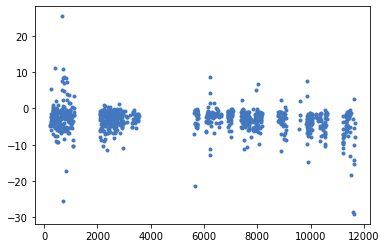

In [18]:
plt.plot(coeffs.installation_id, coeffs.beta1, '.', c="#4378BF")

In [11]:
installations_list = pd.read_csv('installations.csv')

In [12]:
installations_list = installations_list[['installation_id', 'elevation', 'geolocation_latitude', 'geolocation_longitude']]
installations_list = installations_list.set_index('installation_id')
installations_list = installations_list[installations_list.index.isin(installations)]

In [13]:
scaler = MinMaxScaler()
coeffs_cl = coeffs[coeffs.set_index('installation_id').index.isin(installations_list.index.tolist())]
coeff_np = scaler.fit_transform(np.array(coeffs_cl.iloc[:, 1:]))
epss = np.linspace(0.01, 0.05, 6)
n_clusters = [i+1 for i in range(6)]

In [14]:
clustering_dbscan = []
clustering_kmeans = []
for i in range(len(epss)):
    clustering_dbscan.append(DBSCAN(eps=epss[i], min_samples=5, algorithm='brute', n_jobs=1).fit_predict(coeff_np))
    clustering_kmeans.append(KMeans(n_clusters=n_clusters[i], n_jobs=1).fit_predict(coeff_np))

In [15]:
geolocation_latitude_center = installations_list.geolocation_latitude.mean()
geolocation_longitude_center = installations_list.geolocation_longitude.mean()

In [20]:
col = ["#4378BF", "#46BAC2", "#8BDCBE", "#AE2C87", "#FFA58C", "#F05A71"]
map_PM10 = folium.Map(location=[geolocation_latitude_center,geolocation_longitude_center], zoom_start=10) 
clustering = clustering_kmeans
no = 2
for lat,lan, i in zip(installations_list.geolocation_latitude.tolist(), installations_list.geolocation_longitude.tolist(), clustering[no]):  
    if i == -1:
        folium.CircleMarker(location=[lat,lan],
                            radius=5,
                            weight=2,
                            color='black',
                            fill_color='black',
                            fill_opacity=0.7).add_to(map_PM10)
    else:
        folium.CircleMarker(location=[lat,lan],
                        radius=5,
                        weight=2,
                        color=col[i%6],
                        fill_color=col[i%6],
                        fill_opacity=0.7).add_to(map_PM10)
map_PM10